# Field Testing Simulation and Metrics Evaluation

This notebook simulates field testing for routing optimization, evaluates navigation performance, and generates synthetic feedback. The workflow includes:

1. Setting up the road network and geospatial data.
2. Simulating field testing scenarios between buildings and landmarks.
3. Generating synthetic feedback based on simulation results.
4. Calculating performance metrics, such as travel time and success rate.

The goal is to assess the effectiveness of routing optimizations and identify potential areas for improvement.

In [ ]:
import osmnx as ox
import networkx as nx
from tqdm import tqdm
import pandas as pd
from multiprocessing import Pool, cpu_count
import itertools


def heuristic(u, v, G):
    """
    Custom heuristic function for A* algorithm that calculates great-circle distance.
    Args:
        u (int): Start node ID.
        v (int): End node ID.
        G (networkx.Graph): Road network graph.
    Returns:
        float: Great-circle distance between u and v.
    """
    try:
        u_lat, u_lon = G.nodes[u]['y'], G.nodes[u]['x']
        v_lat, v_lon = G.nodes[v]['y'], G.nodes[v]['x']
        return ox.distance.great_circle_vec(u_lat, u_lon, v_lat, v_lon)
    except KeyError as e:
        raise ValueError(f"Missing node attributes for {u} or {v}: {e}")


def process_scenario(args):
    """
    Process a single field-testing scenario for multiprocessing.
    Args:
        args (tuple): Tuple containing building, landmark, and the graph.
    Returns:
        dict: Result of the simulation scenario.
    """
    building, random_landmark, G = args
    try:
        building_coords = (building['latitude'], building['longitude'])
        landmark_coords = (random_landmark['lat'], random_landmark['lon'])

        building_node = ox.distance.nearest_nodes(G, building_coords[1], building_coords[0])
        landmark_node = ox.distance.nearest_nodes(G, landmark_coords[1], landmark_coords[0])

        if not nx.has_path(G, building_node, landmark_node):
            return {
                'Building': f"({building_coords[0]}, {building_coords[1]})",
                'Landmark': f"({landmark_coords[0]}, {landmark_coords[1]}) - {random_landmark['tags_name']}",
                'Path Length': None,
                'Travel Time (s)': None,
                'Status': 'Failed',
                'Error': 'No path exists between nodes'
            }

        path = nx.astar_path(
            G,
            building_node,
            landmark_node,
            heuristic=lambda u, v: heuristic(u, v, G),
            weight='travel_time'
        )
        path_length = len(path)
        # Corrected travel time computation
        travel_time = sum(
            G.get_edge_data(path[i], path[i+1])[0].get('travel_time', 0)  # Retrieve travel time for exact edge
            for i in range(len(path)-1)
        )

        return {
            'Building': f"({building_coords[0]}, {building_coords[1]})",
            'Landmark': f"({landmark_coords[0]}, {landmark_coords[1]}) - {random_landmark['tags_name']}",
            'Path Length': path_length,
            'Travel Time (s)': travel_time,
            'Status': 'Success'
        }
    except Exception as e:
        return {
            'Building': f"({building['latitude']}, {building['longitude']})",
            'Landmark': f"({random_landmark['lat']}, {random_landmark['lon']}) - {random_landmark['tags_name']}",
            'Path Length': None,
            'Travel Time (s)': None,
            'Status': 'Failed',
            'Error': str(e)
        }

def simulate_field_testing(buildings_df, landmarks_df, G, num_scenarios=1000):
    """
    Simulate field testing for landmark-based addressing and pathfinding using multiprocessing.
    Args:
        buildings_df (pd.DataFrame): Building data with latitude and longitude.
        landmarks_df (pd.DataFrame): Landmark data with latitude, longitude, and names.
        G (networkx.Graph): Road network graph.
        num_scenarios (int): Number of test scenarios to simulate.
    Returns:
        pd.DataFrame: Results of simulated testing.
    """
    if num_scenarios > len(buildings_df):
        raise ValueError("Number of scenarios cannot exceed the number of buildings.")
    
    if num_scenarios == 0:
        building_sample = buildings_df
        landmark_sample = landmarks_df
        num_scenarios = len(buildings_df)
    else:
        building_sample = buildings_df.sample(num_scenarios)
        landmark_sample = landmarks_df.sample(min(num_scenarios, len(landmarks_df)))

    # Create arguments for multiprocessing
    args = zip(building_sample.to_dict('records'), itertools.cycle(landmark_sample.to_dict('records')), itertools.repeat(G))

    # Utilize all available CPUs
    with Pool(cpu_count()) as pool:
        results = list(tqdm(pool.imap(process_scenario, args), total=num_scenarios, desc="Simulating Field Testing"))

    return pd.DataFrame(results)


# Load the graph and datasets
G = ox.graph_from_place("Kathmandu, Nepal", network_type="drive")

# Add speed and travel time attributes to the graph
G = ox.add_edge_speeds(G)  # Add speed limits to edges
G = ox.add_edge_travel_times(G)  # Calculate travel time based on speed and length

# Validate the edge attributes (optional)
for u, v, data in list(G.edges(data=True))[:5]:
    print(u, v, data)

# Load datasets
buildings = pd.read_csv('./data/kathmandu_buildings.csv')
landmarks = pd.read_csv('./data/cleaned_landmarks.csv')

# Simulate field testing
simulation_results = simulate_field_testing(buildings, landmarks, G, num_scenarios=0) # tweak the number of scenarios here if needed
simulation_results.to_csv('./data/simulated_field_testing_results.csv', index=False)
print("Simulation completed. Results saved to './data/simulated_field_testing_results.csv'.")


/users/smalla/landmark-based-urban-navigation/venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


31019057 2169068697 {'osmid': 171603743, 'lanes': '3', 'ref': 'F26', 'name': 'चाबहिल-बौद्ध-जोरपाटी सडक', 'highway': 'primary', 'width': '14', 'oneway': False, 'reversed': True, 'length': np.float64(46.559), 'speed_kph': 35.5, 'travel_time': 4.7}
31019057 724349918 {'osmid': 171603743, 'lanes': '3', 'ref': 'F26', 'name': 'चाबहिल-बौद्ध-जोरपाटी सडक', 'highway': 'primary', 'width': '14', 'oneway': False, 'reversed': False, 'length': np.float64(187.325), 'geometry': <LINESTRING (85.364 27.72, 85.363 27.72, 85.363 27.721, 85.362 27.721, 85.36...>, 'speed_kph': 35.5, 'travel_time': 19.0}
31019057 5622458522 {'osmid': [588729673, 588729674, 588729675], 'highway': 'residential', 'oneway': False, 'reversed': False, 'length': np.float64(136.057), 'geometry': <LINESTRING (85.364 27.72, 85.364 27.721, 85.364 27.721, 85.364 27.721, 85.3...>, 'speed_kph': 24.5, 'travel_time': 20.0}
31019141 2126598729 {'osmid': 4825630, 'oneway': True, 'lanes': '2', 'name': 'कान्ति पथ', 'highway': 'primary', 'width':

Simulating Field Testing:   4%|▍         | 5913/149054 [28:21<11:12:22,  3.55it/s]

Number of buildings: 149054
Number of landmarks: 7765
Number of simulation results: 10


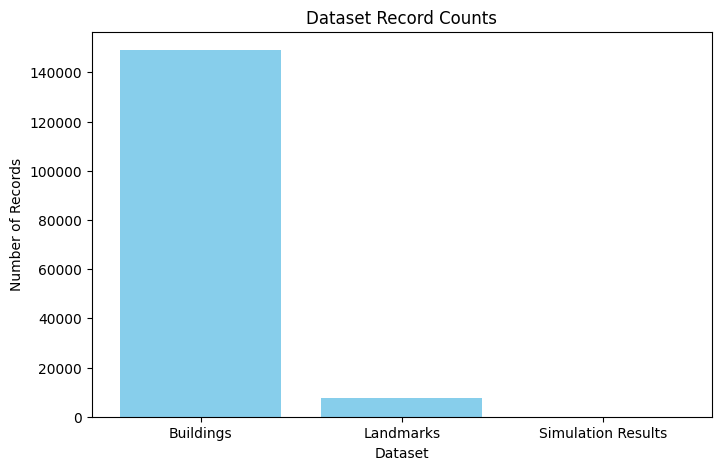


Dataset Summary:
              Dataset   Count
0           Buildings  149054
1           Landmarks    7765
2  Simulation Results      10


In [2]:
# Import necessary libraries
import matplotlib.pyplot as plt
import pandas as pd

# Visualize the number of records in each dataset
print("Number of buildings:", len(buildings))
print("Number of landmarks:", len(landmarks))
print("Number of simulation results:", len(simulation_results))

# Create a summary of dataset sizes
summary_stats = {
    "Dataset": ["Buildings", "Landmarks", "Simulation Results"],
    "Count": [len(buildings), len(landmarks), len(simulation_results)]
}

# Plot dataset counts
plt.figure(figsize=(8, 5))
plt.bar(summary_stats["Dataset"], summary_stats["Count"], color='skyblue')
plt.title("Dataset Record Counts")
plt.xlabel("Dataset")
plt.ylabel("Number of Records")
plt.show()

# Display a table summarizing the dataset counts
summary_table = pd.DataFrame(summary_stats)
print("\nDataset Summary:")
print(summary_table)


In [3]:
# Display the first few rows of simulation results
print("\nPreview of simulation results:")
simulation_results


Preview of simulation results:


,Building,Landmark,Path Length,Travel Time (s),Status
0,"(27.69636534795584, 85.30758771868153)","(27.7203029, 85.3512059) - Stupa community hos...",90,883.7,Success
1,"(27.71660505, 85.342233)","(27.7183368, 85.3470781) - Hamro bhetghat Rodh...",15,136.3,Success
2,"(27.71497899545228, 85.29905142221061)","(27.7389793, 85.3382731) - Nimto Restro And Bar",86,784.6,Success
3,"(27.728312000000003, 85.3198967)","(27.6829433, 85.3434407) - Tedi Pharmacy",112,1135.4,Success
4,"(27.69021812879776, 85.34775889056178)","(27.7109936, 85.3111151) - लुल्बिनी तन्दुरी र ...",69,757.8,Success
5,"(27.68231376350843, 85.34605120601329)","(27.6756886, 85.385366) - Prism Savings And Cr...",54,543.6,Success
6,"(27.71113245, 85.31204199999999)","(27.7392088, 85.3392954) - Richmond Food Cafe",57,785.3,Success
7,"(27.7219023124812, 85.32294630635832)","(27.6295866, 85.5257384) - Radhakrishna Bachat...",132,1191.0,Success
8,"(27.714647718218515, 85.29953840289019)","(27.6861744, 85.2771876) - Maitinagar Pharmacy",84,980.3,Success
9,"(27.694831227303126, 85.33580984445484)","(27.7396211, 85.337974) - Agricultural Develop...",75,714.6,Success


## Geospatial and Graph Setup

This section initializes the road network graph using OSMnx, loads datasets containing building and landmark information, and defines helper functions, such as a custom heuristic for the A* algorithm.

In [5]:
import random

def generate_synthetic_feedback(simulation_results):
    """
    Generate synthetic feedback based on simulated field testing results.

    Args:
        simulation_results (pd.DataFrame): Results from simulated field testing.

    Returns:
        pd.DataFrame: Synthetic feedback with performance metrics.
    """
    feedback = []
    for _, row in simulation_results.iterrows():
        if row['Path Length'] and row['Travel Time (s)']:
            feedback.append({
                'Scenario': f"Building {row['Building']} to Landmark {row['Landmark']}",
                'Feedback': "Navigation successful and efficient.",
                'Rating': random.randint(8, 10) if row['Travel Time (s)'] < 300 else random.randint(6, 8)
            })
        else:
            feedback.append({
                'Scenario': f"Building {row['Building']} to Landmark {row['Landmark']}",
                'Feedback': "Navigation failed or suboptimal.",
                'Rating': random.randint(3, 5)
            })

    return pd.DataFrame(feedback)

# Generate synthetic feedback
synthetic_feedback = generate_synthetic_feedback(simulation_results)
synthetic_feedback.to_csv('./data/synthetic_feedback.csv', index=False)
print("Synthetic feedback generated. Results saved to './data/synthetic_feedback.csv'.")


Synthetic feedback generated. Results saved to './data/synthetic_feedback.csv'.


## Field Testing Simulation

The field-testing simulation involves generating random scenarios between buildings and landmarks, computing paths using the A* algorithm, and measuring travel time and path length. Multiprocessing is utilized to speed up the simulations.

In [6]:
def calculate_metrics(simulation_results):
    """
    Calculate performance metrics from simulated results.

    Args:
        simulation_results (pd.DataFrame): Simulated field testing results.

    Returns:
        dict: Calculated performance metrics.
    """
    successful_paths = simulation_results[simulation_results['Path Length'].notnull()]
    avg_travel_time = successful_paths['Travel Time (s)'].mean()
    avg_path_length = successful_paths['Path Length'].mean()
    success_rate = len(successful_paths) / len(simulation_results) * 100

    return {
        'Average Travel Time (s)': avg_travel_time,
        'Average Path Length': avg_path_length,
        'Success Rate (%)': success_rate
    }

# Calculate metrics
metrics = calculate_metrics(simulation_results)
print("Performance Metrics:", metrics)


Performance Metrics: {'Average Travel Time (s)': np.float64(791.26), 'Average Path Length': np.float64(77.4), 'Success Rate (%)': 100.0}


## Synthetic Feedback Generation

Based on the results of the field-testing simulation, synthetic feedback is generated. Each scenario is rated and categorized as successful or suboptimal based on travel time and pathfinding results.

In [ ]:
# Performance Metrics: {'Average Travel Time (s)': np.float64(0.0), 'Average Path Length': np.float64(78.93813387423936), 'Success Rate (%)': 98.6}

## Performance Metrics Calculation

Key metrics such as average travel time, average path length, and success rate are calculated from the simulation results. These metrics help evaluate the overall performance of the routing optimization.

## Conclusion

The notebook demonstrates a systematic approach to simulating and evaluating routing performance. By analyzing synthetic feedback and performance metrics, insights can be gained to refine routing strategies. Future extensions could include:

- Incorporating real-world feedback for validation.
- Exploring other pathfinding algorithms for comparison.
- Enhancing the simulation with additional datasets or constraints.